# [MNIST](https://bit.ly/3xC2lpZ)
### Celem jest rozwiązanie MNIST dzięki użyciu sieci konwolucyjnych. 

In [2]:
import numpy as np
np.random.seed(0) 

#Tensorflow
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.datasets import mnist

from livelossplot import PlotLossesKeras #<= automatyczne tworzenie krzywej uczenia się

import matplotlib.pyplot as plt
%matplotlib inline

## Wczytujemy dane

In [3]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape, X_test.shape)

(60000, 28, 28) (10000, 28, 28)


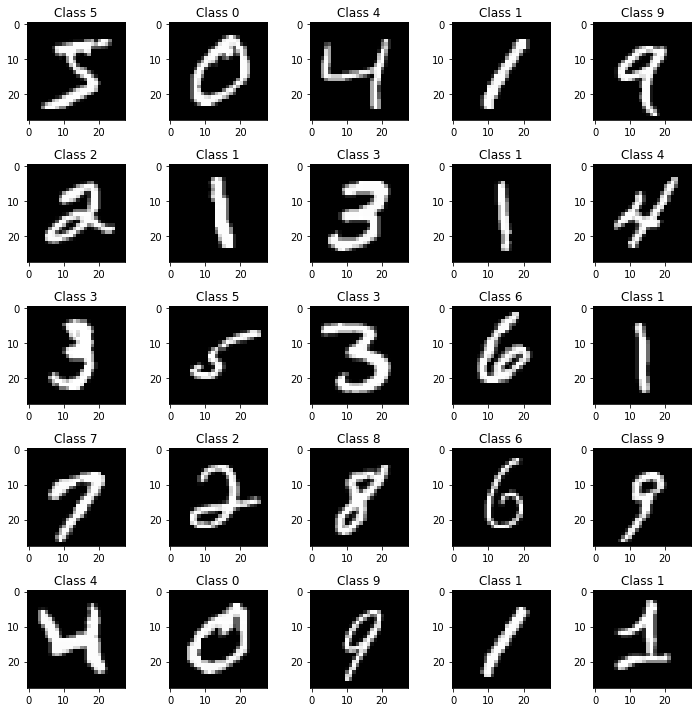

In [4]:
fig = plt.figure(figsize=(10, 10))
for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(X_train[idx], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[idx]))
    
plt.tight_layout()

## Przygotowujemy dane

Zwróć uwagę, że **X_train** oraz **X_test** ma trzy wymiary: liczbę obiektów i rozmiar zdjęcia 28x28. Brakuje informacji o liczbie kanałów, która będzie potrzebna dla warstwy konwolucyjnej, więc trzeba ją dodać (podobnie jak zrobiliśmy w Lesson5.5).

Żeby nie było zbyt łatwo, są na to różne standardy (w zależności od backendu) i czasami informację o kanale dodaje się z przodu, a czasami z tyłu (taka sobie "prawdziwa i surowa informatyka". Trochę przypomina to walkę z [kolejnością bajtów](https://bit.ly/3gSInRH). 

In [5]:
K.image_data_format()

'channels_last'

`channels_last` oznacza, że informacja o liczbie kanałów będzie na końcu. Dodajemy prosty warunek (trochę wybiegając w przyszłość), gdyby jednak miała być na początku.

Chodzi o to, żeby kod potrafił działać w różnych konfiguracjach.

In [6]:
img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_last':
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
else:
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
    
print(X_train.shape, X_test.shape)

(60000, 28, 28, 1) (10000, 28, 28, 1)


Teraz dane mają już cztery wymiary: liczba obiektów, rozmiar zdjęcia 28x28 i liczba kanałów. W naszym przypadku jest to tylko jeden kanał (szarość).

Następnym krokiem jest normalizacja wartości. Oczekiwany wynik to taki, żeby wartości były pomiędzy 0 i 1 (zbiór domknięty).

#### Dlaczego [0, 1]?
Pamiętasz, że pojedyncza jednostka sieci neuronowej to zwykły model liniowy? Dobór wag jest czuły na wartości, którymi operuje, stąd konieczność używania wartości znormalizowanych.

In [7]:
# normalizacja danych
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train /= 255
X_test /= 255

num_classes = 10

# one-hot encoding dla zmiennej docelowej
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Prosta architektura

#### Dwie warstwy konwolucyjne.
W jaki sposób dobieramy liczby? Zwykle `kernel_size` dla `conv2d` wynosi **3x3**, `pool_size` wynosi **2x2**. Funkcja aktywacji - wszędzie `relu`, oprócz ostatniej warstwy - tam `softmax`.

Liczba filtrów (w `conv2d`) na początek może być 32. W kolejnej warstwie 2 razy tyle (czyli 64).

To są wartości od których możesz zacząć. Przy czym `kernel_size` z wartościami **3x3** i `pool_size` **2x2** raczej będą zawsze. Po prostu, empirycznie wyszło, że takie wartości dobrze się sprawdzają.

In [8]:
def get_simple_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 
        
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(), # spłaszczanie danych, aby połączyć warstwy konwolucyjne z fully connected layers
        
        Dense(1024, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

get_simple_cnn().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)          0

2022-10-23 15:20:08.218226: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Zwróć uwagę na liczbę parametrów oraz na środkową kolumnę `Output Shape`. Widać tutaj, jak zmienia się rozmiar zdjęcia w czasie. Mając już architekturę, kolejnym krokiem będzie skompilowanie tego. Możesz to potraktować jako "transakcję", że architektura jest zdefiniowana.
- `categorical_crossentropy` funkcja kosztu, dzięki której jest robiona optymalizacja.
- `Adam` optymalizator, ale teraz nie jest ważne dlaczego taki (jakiś trzeba było wybrać).
- `accuracy` zewnętrzna metryka sukcesu.

Na razie nie przejmuj się tym, którego optymalizatora użyć. Jest ich sporo, więc możesz użyć na początek np. `Adam`.

In [9]:
model = get_simple_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Trenujemy
Trenowanie chwilę będzie trwało. Krzywa uczenia również będzie stopniowo się pojawiać, także trzeba się uzbroić w cierpliwość :)

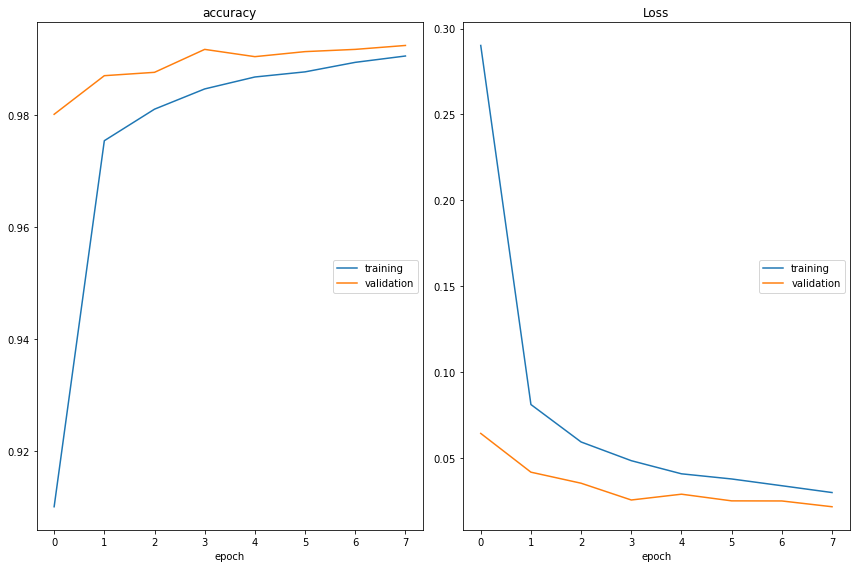

accuracy
	training         	 (min:    0.910, max:    0.991, cur:    0.991)
	validation       	 (min:    0.980, max:    0.993, cur:    0.993)
Loss
	training         	 (min:    0.030, max:    0.290, cur:    0.030)
	validation       	 (min:    0.021, max:    0.064, cur:    0.021)
235/235 - 17s - loss: 0.0297 - accuracy: 0.9906 - val_loss: 0.0215 - val_accuracy: 0.9925 - 17s/epoch - 73ms/step


In [10]:
plot_losses = PlotLossesKeras()

history = model.fit(X_train, y_train,
  batch_size=256, epochs=8,
  verbose=2,
  callbacks=[plot_losses],
  validation_data=(X_test, y_test)
)

## Sprawdzamy

In [11]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.02145427279174328
Test accuracy: 0.9925000071525574
CNN Error: 0.75%


## Krzywa uczenia się
Można również narysować krzywą w ten sposób:

In [12]:
def draw_learning_curve(history, key='accuracy', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(history.history[key])
    plt.plot(history.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

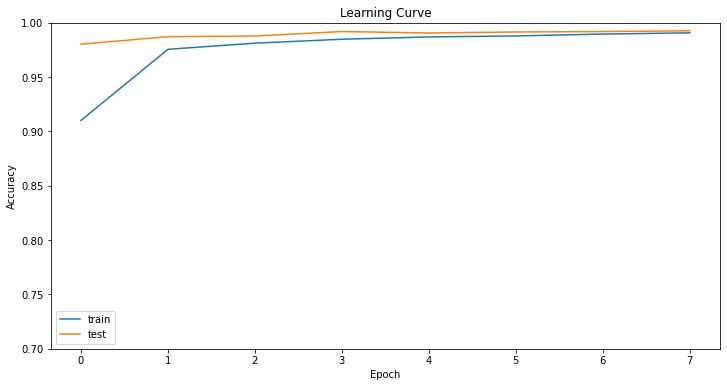

In [13]:
draw_learning_curve(history, 'accuracy', ylim=(0.7, 1.))

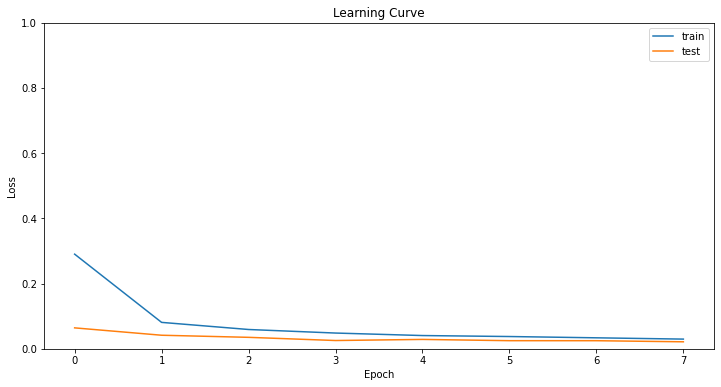

In [14]:
draw_learning_curve(history, 'loss', ylim=(0., 1.))

Teraz zróbmy jeden trick, którego już spróbowaliśmy w lesson6.2, a który dość często stosuje się w bardziej złożonych zadaniach. 

Dotychczas był wzór: `conv + pool`, a teraz będzie: `conv + conv + pool`.

In [15]:
def get_double_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        Conv2D(32, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 
        
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(), # spłaszczanie danych, aby połączyć warstwy konwolucyjne z fully connected layers
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

model = get_double_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          36928     
                                                      

Zwróć uwagę, że została zmniejszona warstwa "fully connected" z `1024` na `512`. Przez to, że dodaliśmy dodatkowe warstwy konwolucyjne udało się zredukować rozmiar. Przyjrzyj się dokładnie kolumnie `Output Shape`.

## Trenujemy

In [16]:
history = model.fit(X_train, y_train,
          batch_size=256,
          epochs=12,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/12
235/235 [==============================] - 32s 136ms/step - loss: 0.2817 - accuracy: 0.9101 - val_loss: 0.0464 - val_accuracy: 0.9827
Epoch 2/12
235/235 [==============================] - 35s 147ms/step - loss: 0.0712 - accuracy: 0.9780 - val_loss: 0.0301 - val_accuracy: 0.9900
Epoch 3/12
235/235 [==============================] - 41s 173ms/step - loss: 0.0513 - accuracy: 0.9844 - val_loss: 0.0222 - val_accuracy: 0.9934
Epoch 4/12
235/235 [==============================] - 34s 144ms/step - loss: 0.0413 - accuracy: 0.9869 - val_loss: 0.0236 - val_accuracy: 0.9922
Epoch 5/12
235/235 [==============================] - 32s 137ms/step - loss: 0.0360 - accuracy: 0.9885 - val_loss: 0.0195 - val_accuracy: 0.9936
Epoch 6/12
235/235 [==============================] - 32s 137ms/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 0.0204 - val_accuracy: 0.9933
Epoch 7/12
235/235 [==============================] - 32s 137ms/step - loss: 0.0272 - accuracy: 0.9913 - val_loss: 0.0189 - val_ac

## Sprawdzamy

In [17]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.016911612823605537
Test accuracy: 0.9951000213623047
CNN Error: 0.49%


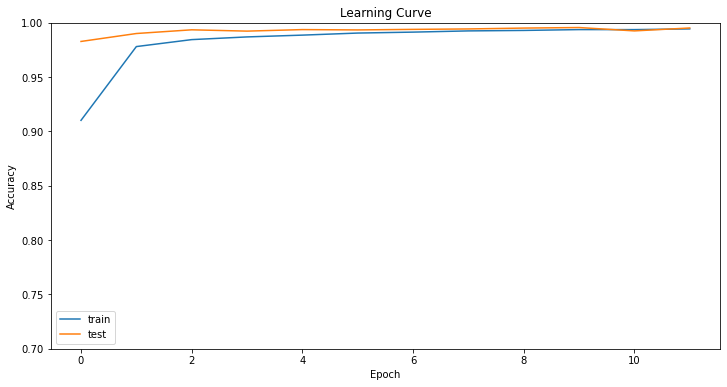

In [18]:
draw_learning_curve(history, 'accuracy', ylim=(0.7, 1.))

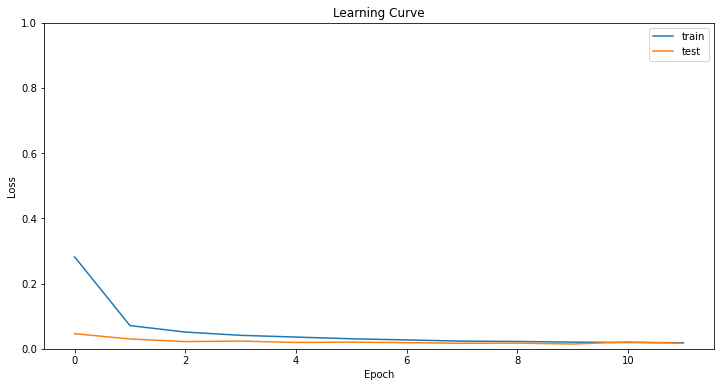

In [19]:
draw_learning_curve(history, 'loss', ylim=(0., 1.))

## Gdzie się mylimy?
Swoją drogą, wynik klasyfikacji jest już całkiem fajny. Warto zobaczyć, jak wyglądają cyfry, na których model się myli :).

In [20]:
y_pred = model.predict(X_test)

313/313 [==============================] - 4s 12ms/step


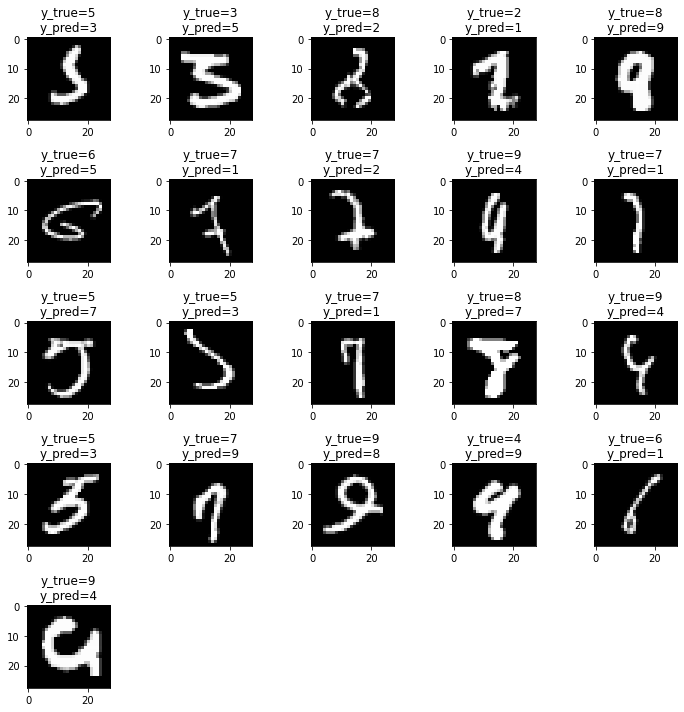

In [21]:
def get_diff(y_test, y_pred):
    for idx, (a, b) in enumerate(zip(y_test, y_pred)):
        if np.argmax(a) == np.argmax(b): continue
        yield idx, np.argmax(a), np.argmax(b)

limit = 20
cur_limit = 0
fig = plt.figure(figsize=(10, 10))
X_test_plot = X_test.reshape( X_test.shape[:-1] )

for it, (idx, y_test_val, y_pred_val) in enumerate(get_diff(y_test, y_pred)):
    if cur_limit > limit: break
      
    plt.subplot(5,5,it+1)
    plt.imshow(X_test_plot[idx], cmap='gray', interpolation='none')
    plt.title('y_true={0}\ny_pred={1}'.format(y_test_val, y_pred_val))
    plt.tight_layout()
        
    cur_limit += 1

Jak widać, tam gdzie model się myli, człowiek również mógłby z trudem rozpoznać, jaka to liczba :D.

## Zadanie 6.3.1
Teraz mamy dwie warstwy konwolucyjne
- pierwsza: conv32 + conv32 + pool
- druga: conv64 + conv64 + pool

Dodaj trzecią warstwę konwolucyjną. Wzór będzie podobny, liczba filtrów będzie dwa razy większa niż poprzednio czyli 128.

**Uwaga!** Zadanie wymaga trochę myślenia, poniżej jest kilka podpowiedzi, jak zbudować sieć. Jeśli nadal nie wiesz, to jeszcze niżej jest gotowe rozwiązanie.

*Swoją drogą*, oczywiście możesz eksperymentować, zaproponowane rozwiązanie jest jedynie propozycją, z chęcią zobaczę Twoją wersję :) 

In [22]:
def get_triple_cnn():
    return Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25), 

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same',),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same',),
        Conv2D(128, kernel_size=(3, 3), activation='relu'),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(), # spłaszczanie danych, aby połączyć warstwy konwolucyjne z fully connected layers

        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

model = get_triple_cnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_9 (Conv2D)           (None, 26, 26, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 13, 13, 64)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        36928     
                                                                 
 conv2d_11 (Conv2D)          (None, 11, 11, 64)        36928     
                                                      

## Trenujemy ⌛️⌛️⌛️
Uwaga! Ten model będzie się trenował kilkadziesiąt minut, więc warto zaplanować przerwę w tym czasie :).

In [23]:
history = model.fit(X_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(X_test, y_test))

Epoch 1/12
469/469 [==============================] - 77s 163ms/step - loss: 0.3721 - accuracy: 0.8781 - val_loss: 0.0430 - val_accuracy: 0.9877
Epoch 2/12
469/469 [==============================] - 74s 158ms/step - loss: 0.0843 - accuracy: 0.9773 - val_loss: 0.0297 - val_accuracy: 0.9910
Epoch 3/12
469/469 [==============================] - 73s 157ms/step - loss: 0.0585 - accuracy: 0.9840 - val_loss: 0.0246 - val_accuracy: 0.9927
Epoch 4/12
469/469 [==============================] - 75s 160ms/step - loss: 0.0497 - accuracy: 0.9865 - val_loss: 0.0261 - val_accuracy: 0.9932
Epoch 5/12
469/469 [==============================] - 77s 165ms/step - loss: 0.0401 - accuracy: 0.9890 - val_loss: 0.0217 - val_accuracy: 0.9938
Epoch 6/12
469/469 [==============================] - 76s 163ms/step - loss: 0.0364 - accuracy: 0.9901 - val_loss: 0.0208 - val_accuracy: 0.9941
Epoch 7/12
469/469 [==============================] - 74s 157ms/step - loss: 0.0326 - accuracy: 0.9915 - val_loss: 0.0215 - val_ac

## Sprawdzamy

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

print("CNN Error: %.2f%%" % (100-score[1]*100))

Test loss: 0.023497875779867172
Test accuracy: 0.9933000206947327
CNN Error: 0.67%


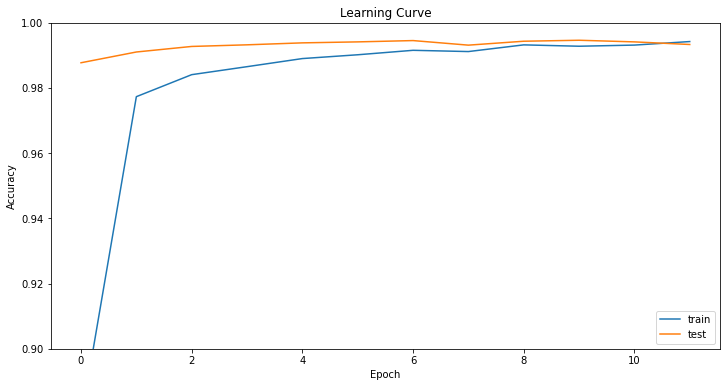

In [25]:
draw_learning_curve(history, 'accuracy', ylim=(0.9, 1.))

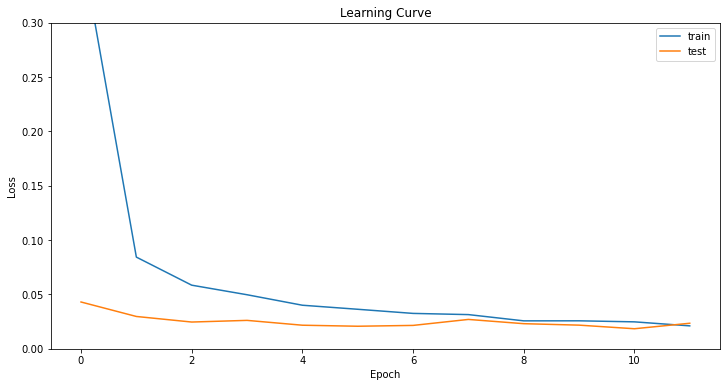

In [26]:
draw_learning_curve(history, 'loss', ylim=(0., .3))

## Przydatne linki:
- [Who is the best in MNIST?](https://bit.ly/2RfBwXQ)
- [Understanding Convolutional Neural Networks: Making a Handwritten Digit Calculator](https://bit.ly/3eN3MJC)
- [tensorflow-mnist-cnn](https://bit.ly/3vzDbq5)
- <a href="http://parneetk.github.io/blog/cnn-mnist/">Convolutional Neural Networks (CNN) for MNIST Dataset</a>
- [Cutting-Edge Face Recognition is Complicated. These Spreadsheets Make it Easier](https://bit.ly/3t9BgqK)
- [Convolutional Neural Net in Tensorflow](https://bit.ly/3gU0mHM)